In [15]:
import tensorflow as tf
import numpy as np
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import clone_model
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import matplotlib.pyplot as plt
from numpy.random import default_rng
from tensorflow.keras.models import load_model
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

In [3]:
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
train_images.shape

(50000, 32, 32, 3)

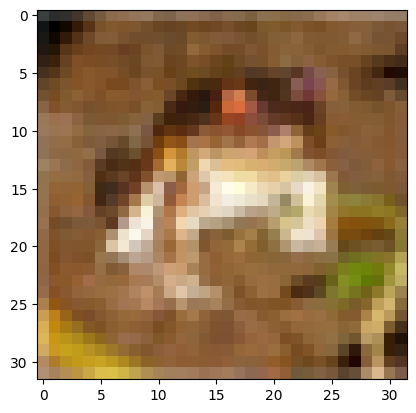

In [5]:
plt.imshow(train_images[0])

In [6]:
num_classes = 10
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)

In [7]:
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

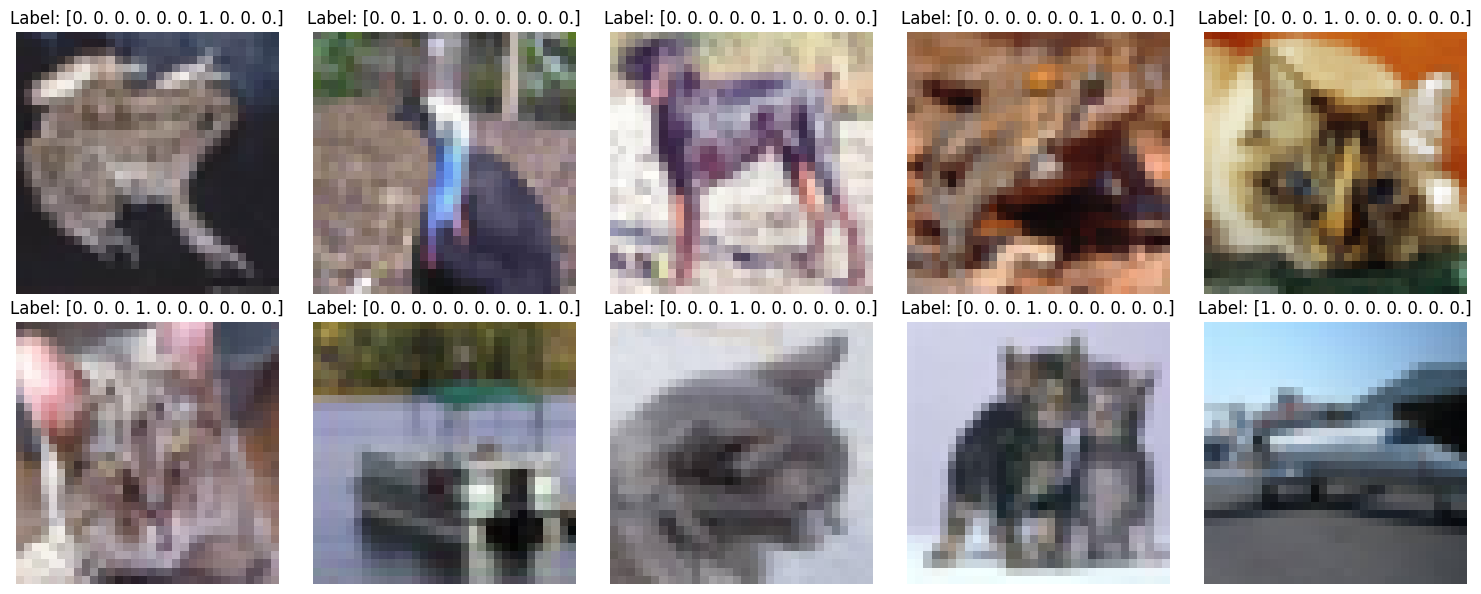

In [8]:
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for img, lbl, ax in zip(train_images, train_labels, axes):
    ax.imshow(img)
    ax.set_title(f'Label: {lbl}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam



In [10]:
def residual_block(inputs, filters, stride=1, block_id=1):
    x = Conv2D(filters, (3,3), strides=stride, padding='same', kernel_initializer='he_normal', name=f'res_block{block_id}_conv1')(inputs)
    x = layers.BatchNormalization(name=f'res_block{block_id}_bn1')(x)
    x = layers.Activation('relu', name=f'res_block{block_id}_relu1')(x)

    x = Conv2D(filters, (3,3), strides=1, padding='same', kernel_initializer='he_normal', name=f'res_block{block_id}_conv2')(x)
    x = layers.BatchNormalization(name=f'res_block{block_id}_bn2')(x)

    if stride != 1 or inputs.shape[-1] != filters:
        shortcut = Conv2D(filters, (1,1), strides=stride, padding='same', kernel_initializer='he_normal', name=f'res_block{block_id}_conv_shortcut')(inputs)
        shortcut = layers.BatchNormalization(name=f'res_block{block_id}_bn_shortcut')(shortcut)
    else:
        shortcut = inputs

    x = layers.add([x, shortcut], name=f'res_block{block_id}_add')
    x = layers.Activation('relu', name=f'res_block{block_id}_relu2')(x)
    return x

In [11]:
def ResNet20(input_shape=(32, 32, 3), num_classes=10):
    """
    Builds the ResNet20 model with named Conv2D layers.

    Args:
        input_shape (tuple): Shape of the input images.
        num_classes (int): Number of output classes.

    Returns:
        model: Keras Model instance.
    """
    inputs = layers.Input(shape=input_shape, name='input_layer')

    # Initial convolutional layer
    x = layers.Conv2D(16, (3, 3), strides=1, padding='same',
                      kernel_initializer='he_normal',
                      name='conv1')(inputs)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu', name='relu_conv1')(x)

    # Stage 1: 3 Residual Blocks with 16 filters
    for i in range(1, 4):
        x = residual_block(x, filters=16, stride=1, block_id=i)

    # Stage 2: 3 Residual Blocks with 32 filters
    for i in range(4, 7):
        if i == 4:
            # First block in Stage 2 with stride=2
            x = residual_block(x, filters=32, stride=2, block_id=i)
        else:
            x = residual_block(x, filters=32, stride=1, block_id=i)

    # Stage 3: 3 Residual Blocks with 64 filters
    for i in range(7, 10):
        if i == 7:
            # First block in Stage 3 with stride=2
            x = residual_block(x, filters=64, stride=2, block_id=i)
        else:
            x = residual_block(x, filters=64, stride=1, block_id=i)

    # Global Average Pooling
    x = layers.GlobalAveragePooling2D(name='global_avg_pool')(x)

    # Fully Connected Layer
    outputs = layers.Dense(num_classes, activation='softmax',
                           kernel_initializer='he_normal',
                           name='fc')(x)

    # Create the model
    model = models.Model(inputs=inputs, outputs=outputs, name='ResNet20')
    return model


In [12]:
model = ResNet20(input_shape=(32, 32, 3), num_classes=10)

In [13]:
model.summary()

Model: "ResNet20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1 (Conv2D)      │ (None, 32, 32,    │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 32, 32,    │         64 │ conv1[0][0]       │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu_conv1          │ (None, 32, 32,    │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_conv1    │ (None, 32, 32,    │      2,320 │ relu_conv1[0][0]  │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_bn1      │ (None, 32, 32,    │         64 │ res_block1_conv1… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_relu1    │ (None, 32, 32,    │          0 │ res_block1_bn1[0… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_conv2    │ (None, 32, 32,    │      2,320 │ res_block1_relu1… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_bn2      │ (None, 32, 32,    │         64 │ res_block1_conv2… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_add      │ (None, 32, 32,    │          0 │ res_block1_bn2[0… │
│ (Add)               │ 16)               │            │ relu_conv1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block1_relu2    │ (None, 32, 32,    │          0 │ res_block1_add[0… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_conv1    │ (None, 32, 32,    │      2,320 │ res_block1_relu2… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_bn1      │ (None, 32, 32,    │         64 │ res_block2_conv1… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_relu1    │ (None, 32, 32,    │          0 │ res_block2_bn1[0… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_conv2    │ (None, 32, 32,    │      2,320 │ res_block2_relu1… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_bn2      │ (None, 32, 32,    │         64 │ res_block2_conv2… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ res_block2_add      │ (None, 32, 32,    │          0 │ res_block2_bn2[0

 Total params: 274,826 (1.05 MB)

 Trainable params: 273,258 (1.04 MB)

 Non-trainable params: 1,568 (6.12 KB)

In [22]:
def get_flops(model, input_shape):
    # Create a concrete function from the Keras model
    @tf.function
    def model_func(x):
        return model(x)
    
    # Get the concrete function
    concrete_func = model_func.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    
    # Convert variables to constants and get the frozen graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    frozen_graph = frozen_func.graph.as_graph_def()
    
    # Use TensorFlow's profiler
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(frozen_graph, name='')
        run_meta = tf.compat.v1.RunMetadata()
        with tf.compat.v1.Session(graph=graph) as sess:
            flops = tf.compat.v1.profiler.profile(
                graph=graph,
                run_meta=run_meta,
                cmd='op',
                options=tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
            )
            return flops.total_float_ops

In [14]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [17]:
early_stop = EarlyStopping(monitor='val_accuracy', patience=10, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr = 1e-6, verbose=1)

In [18]:
history = model.fit(train_images, train_labels, epochs=100, batch_size=128, validation_data=(val_images, val_labels), callbacks=[early_stop, reduce_lr])

Epoch 1/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 106s 324ms/step - accuracy: 0.3555 - loss: 1.7986 - val_accuracy: 0.2865 - val_loss: 2.5036 - learning_rate: 0.0010
Epoch 2/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 108s 346ms/step - accuracy: 0.6022 - loss: 1.1166 - val_accuracy: 0.5468 - val_loss: 1.3915 - learning_rate: 0.0010
Epoch 3/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 109s 347ms/step - accuracy: 0.6825 - loss: 0.8983 - val_accuracy: 0.5330 - val_loss: 1.5888 - learning_rate: 0.0010
Epoch 4/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 364ms/step - accuracy: 0.7315 - loss: 0.7629 - val_accuracy: 0.6206 - val_loss: 1.1508 - learning_rate: 0.0010
Epoch 5/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 143s 456ms/step - accuracy: 0.7645 - loss: 0.6643 - val_accuracy: 0.6595 - val_loss: 1.0872 - learning_rate: 0.0010
Epoch 6/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 364ms/step - accuracy: 0.8021 - loss: 0.5662 - val_accuracy: 0.6450 - val_loss: 1.1549 - learning_rate: 0.0010
Epoch 7/100
313/313 ━━━━━━━━━━━━━━━━━━━━ 114s 364ms/step -

In [19]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)


313/313 - 9s - 30ms/step - accuracy: 0.7729 - loss: 1.2113


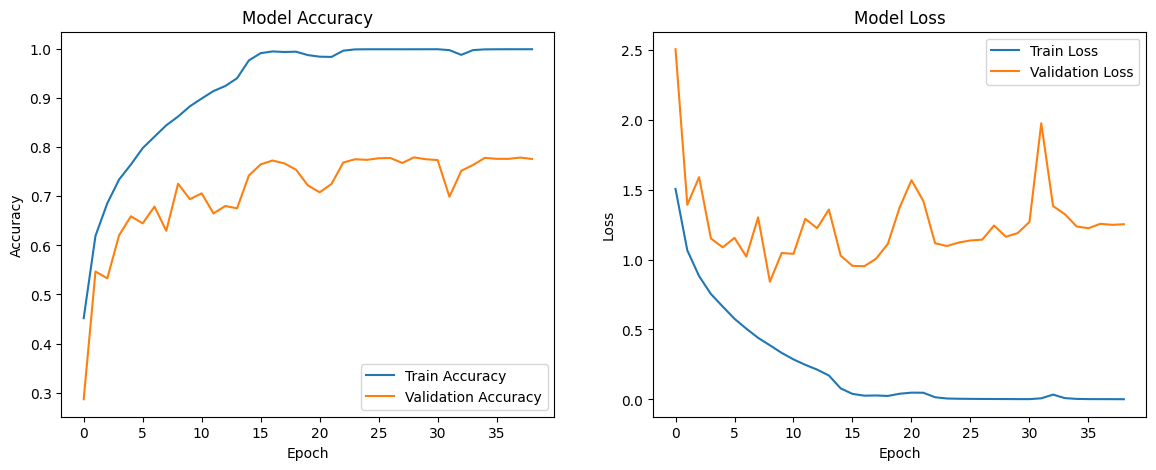

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(14,5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


In [23]:
#for idx, model in enumerate(model_list):
#    model.save(f'model_{idx}.h5')
get_flops(model, train_images.shape)

I0000 00:00:1730123277.205909  858989 devices.cc:76] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0 (Note: TensorFlow was not compiled with CUDA or ROCm support)
I0000 00:00:1730123277.206746  858989 single_machine.cc:361] Starting new session


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
op: The nodes are operation ker

3292746084704